<h2 style=' color: crimson;font-family: Colonna MT; font-weight: 600; font-size: 35px; text-align: Center'>Bubble Chart Visualization</h2>


---

This project provides a Python implementation for creating visually appealing bubble charts with automatic collision detection and layout optimization. The chart is particularly useful for visualizing proportional data where both the size and position of bubbles convey meaningful information.

**Features**

- **Automatic Layout**: Bubbles are automatically arranged to minimize collisions
- **Size Proportional to Data**: Bubble areas accurately represent input values
- **Customizable Appearance:** Control colors, labels, and spacing
- **Optimization Algorithm:** Intelligent bubble positioning with convergence detection
- **High-Quality Output:** Support for high-DPI image export

<h2 style='font-family: Colonna MT; font-weight: 600; font-size: 25px; text-align: left'>1.0. Import Required Libraries</h2>

In [63]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from typing import Optional, List, Union

<h1 style='font-size: 25px; font-family: Colonna MT; font-weight: 600'>2.0. BubbleChart Class</h1>

In [64]:
class BubbleChart:
    def __init__(self, areas: Union[List[float], np.ndarray], bubble_spacing: float = 0):
        self._validate_input(areas, bubble_spacing)
        self._initialize_bubbles(areas, bubble_spacing)
        self._initialize_grid()
        self.com = self._calculate_center_of_mass()
    
    def _validate_input(self, areas: Union[List[float], np.ndarray], bubble_spacing: float):
        if not isinstance(bubble_spacing, (int, float)) or bubble_spacing < 0:
            raise ValueError("Bubble spacing must be a non-negative number")
    
        if len(areas) == 0:
            raise ValueError("Areas list cannot be empty")
    
    def _initialize_bubbles(self, areas: Union[List[float], np.ndarray], bubble_spacing: float):
        areas = np.asarray(areas, dtype=float)
        radii = np.sqrt(areas / np.pi)
        
        self.bubble_spacing = bubble_spacing
        self.bubbles = np.ones((len(areas), 4))  # [x, y, radius, area]
        self.bubbles[:, 2] = radii
        self.bubbles[:, 3] = areas
        
        self.max_step = 2 * self.bubbles[:, 2].max() + self.bubble_spacing
        self.step_dist = self.max_step / 2
    
    def _initialize_grid(self):
        length = np.ceil(np.sqrt(len(self.bubbles)))
        grid = np.arange(length) * self.max_step
        gx, gy = np.meshgrid(grid, grid)
        
        self.bubbles[:, 0] = gx.flatten()[:len(self.bubbles)]
        self.bubbles[:, 1] = gy.flatten()[:len(self.bubbles)]
    
    def _calculate_center_of_mass(self) -> np.ndarray:
        return np.average(
            self.bubbles[:, :2], 
            axis=0, 
            weights=self.bubbles[:, 3]
        )
    
    def _calculate_center_distance(self, bubble: np.ndarray, bubbles: np.ndarray) -> np.ndarray:
        return np.hypot(bubble[0] - bubbles[:, 0], bubble[1] - bubbles[:, 1])
    
    def _calculate_outline_distance(self, bubble: np.ndarray, bubbles: np.ndarray) -> np.ndarray:
        center_distance = self._calculate_center_distance(bubble, bubbles)
        return center_distance - bubble[2] - bubbles[:, 2] - self.bubble_spacing
    
    def _check_collisions(self, bubble: np.ndarray, bubbles: np.ndarray) -> int:
        distance = self._calculate_outline_distance(bubble, bubbles)
        return len(distance[distance < 0])
    
    def _find_collisions(self, bubble: np.ndarray, bubbles: np.ndarray) -> List[int]:
        distance = self._calculate_outline_distance(bubble, bubbles)
        idx_min = np.argmin(distance)
        return [idx_min] if not isinstance(idx_min, np.ndarray) else idx_min.tolist()
    
    def collapse(self, n_iterations: int = 50, convergence_threshold: float = 0.1):
        for _ in range(n_iterations):
            moves = self._perform_iteration()
            if moves / len(self.bubbles) < convergence_threshold:
                self.step_dist /= 2
    
    def _perform_iteration(self) -> int:
        moves = 0
        for i in range(len(self.bubbles)):
            moves += self._adjust_bubble_position(i)
        return moves
    
    def _adjust_bubble_position(self, bubble_index: int) -> bool:
        rest_bubbles = np.delete(self.bubbles, bubble_index, 0)
        moved = False
        moved = self._try_move_toward_center(bubble_index, rest_bubbles)
        if not moved:
            moved = self._try_move_orthogonal(bubble_index, rest_bubbles)
        return moved
    
    def _try_move_toward_center(self, bubble_index: int, rest_bubbles: np.ndarray) -> bool:
        dir_vec = self.com - self.bubbles[bubble_index, :2]
        dir_vec /= np.linalg.norm(dir_vec)
        new_point = self.bubbles[bubble_index, :2] + dir_vec * self.step_dist
        new_bubble = np.append(new_point, self.bubbles[bubble_index, 2:4])
        
        if not self._check_collisions(new_bubble, rest_bubbles):
            self.bubbles[bubble_index, :] = new_bubble
            self.com = self._calculate_center_of_mass()
            return True
        return False
    
    def _try_move_orthogonal(self, bubble_index: int, rest_bubbles: np.ndarray) -> bool:
        for colliding in self._find_collisions(self.bubbles[bubble_index], rest_bubbles):
            dir_vec = rest_bubbles[colliding, :2] - self.bubbles[bubble_index, :2]
            dir_vec /= np.linalg.norm(dir_vec)
            orth = np.array([dir_vec[1], -dir_vec[0]])
            new_point1 = self.bubbles[bubble_index, :2] + orth * self.step_dist
            new_point2 = self.bubbles[bubble_index, :2] - orth * self.step_dist
            dist1 = self._calculate_center_distance(self.com, np.array([new_point1]))
            dist2 = self._calculate_center_distance(self.com, np.array([new_point2]))
            new_point = new_point1 if dist1 < dist2 else new_point2
            new_bubble = np.append(new_point, self.bubbles[bubble_index, 2:4])
            
            if not self._check_collisions(new_bubble, rest_bubbles):
                self.bubbles[bubble_index, :] = new_bubble
                self.com = self._calculate_center_of_mass()
                return True
        return False
    
    def plot(self, ax: plt.Axes, labels: List[str], values: List[Union[int, float]], colors: List[str]):
        self._validate_plot_inputs(labels, values, colors)
        for i in range(len(self.bubbles)):
            self._plot_bubble(ax, i, labels[i], values[i], colors[i])
    
    def _validate_plot_inputs(self, labels: List[str], values: List[Union[int, float]], colors: List[str]):
        if len(labels) != len(self.bubbles) or len(values) != len(self.bubbles) or len(colors) != len(self.bubbles):
            raise ValueError("Labels, values, and colors must have same length as areas")
    
    def _plot_bubble(self, ax: plt.Axes, index: int, label: str, value: Union[int, float], color: str):
        bubble = self.bubbles[index]
        circ = plt.Circle(bubble[:2], bubble[2], color=color)
        ax.add_patch(circ)

        max_radius = np.max(self.bubbles[:, 2])
        min_radius = np.min(self.bubbles[:, 2])

        if max_radius / min_radius > 100:  # Large range of sizes
            normalized_radius = np.log1p(bubble[2]) / np.log1p(max_radius)
        else:
            normalized_radius = bubble[2] / max_radius
        
        base_font_size = 16
        min_font_size = 1
    
        font_size = max(min_font_size, base_font_size * normalized_radius)
        value_font_size = max(min_font_size * 0.7, font_size * 0.7)

        ax.text(bubble[0], bubble[1], label, ha='center', va='center', fontsize=font_size, fontweight='bold')
        ax.text(bubble[0], bubble[1] - bubble[2] * 0.12, str(value), fontweight='bold',
                ha='center', va='center', 
                fontsize=value_font_size, 
                color='black')

class BubbleChartVisualizer:
    @staticmethod
    def create_bubble_chart(
        data: 'pd.DataFrame',
        areas_column: str,
        labels_column: str,
        values_column: str,
        colors_column: str,
        title: str = '',
        figsize: tuple = (10, 10),
        bubble_spacing: float = 0.47,
        save_path: Optional[str] = None,
        dpi: int = 600
    ) -> plt.Figure:
        plt.rcParams.update({ 'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11})
        bubble_chart = BubbleChart(areas=data[areas_column], bubble_spacing=bubble_spacing)
        bubble_chart.collapse()
        fig, ax = plt.subplots( subplot_kw=dict(aspect="equal"), figsize=figsize)
        bubble_chart.plot(ax, data[labels_column], data[values_column], data[colors_column])
        ax.axis("off")
        ax.relim()
        ax.autoscale_view()
        if title:
            ax.set_title(title, fontweight='bold', fontsize=20)
        
        BubbleChartVisualizer._add_credits(ax)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        if save_path:
            plt.savefig(save_path, dpi=dpi)
        
        return fig
    
    @staticmethod
    def _add_credits(ax: plt.Axes):
        pass 
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M")
        left_footnote = "Plot by: Jabulente | Data Source: Dummy Dataset | Data-Driven Insights"
        right_footnote = f"Generated on: {current_time}"
        ax.text(0.01, -0.03, left_footnote, ha='left', va='center', fontsize=8, color='black', transform=ax.transAxes, fontweight='bold')
        ax.text(0.7, -0.03, right_footnote, ha='left', va='center', fontsize=8, color='black', transform=ax.transAxes, fontweight='bold')

<h1 style='font-size: 25px; font-family: Colonna MT; font-weight: 600'>3.0. Basic Usage</h1>

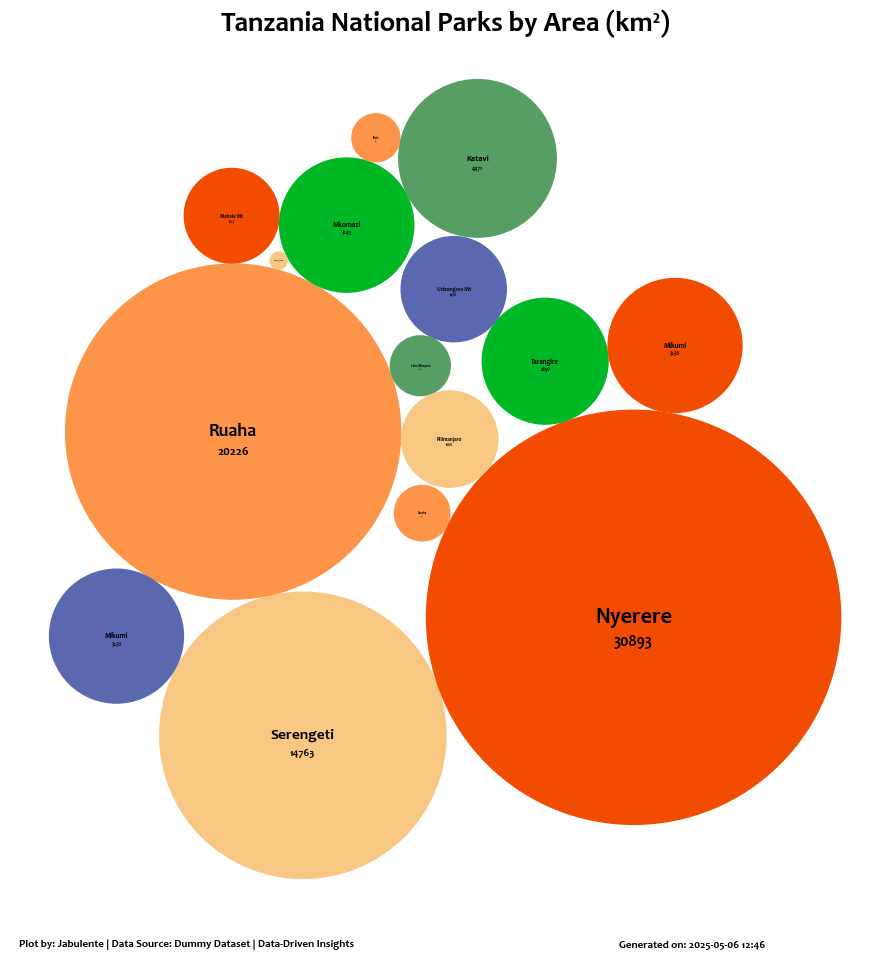

In [65]:
# Data: National Parks in Tanzania
national_parks = pd.DataFrame({
    'Parke_Name': [
        'Serengeti', 'Ruaha', 'Nyerere', 'Tarangire', 'Mikumi',
        'Lake Manyara', 'Kilimanjaro', 'Arusha', 'Mahale Mt', 'Mkomazi',
        'Udzungwa Mt', 'Katavi', 'Gombe Stream', 'Kitulo', 'Mikumi'
    ],
    'Area (km²)': [
        14763, 20226, 30893, 2850, 3230,
        644, 1668, 552, 1613, 3245,
        1990, 4471, 52, 413, 3230
    ],
    'colors': [
        '#F9C784', '#FC944A', '#F24C00', '#00B825', '#5A69AF',
        '#579E65', '#F9C784', '#FC944A', '#F24C00', '#00B825',
        '#5A69AF', '#579E65', '#F9C784', '#FC944A', '#F24C00'
    ]
})

# Create visualization
visualizer = BubbleChartVisualizer()
fig = visualizer.create_bubble_chart(
    data=national_parks,
    areas_column='Area (km²)',
    labels_column='Parke_Name',
    values_column='Area (km²)',
    colors_column='colors',
    title='Tanzania National Parks by Area (km²)'
)
plt.show()

<h1 style='font-size: 25px; font-family: Colonna MT; font-weight: 600'>4.0. Customized Visualization</h1>

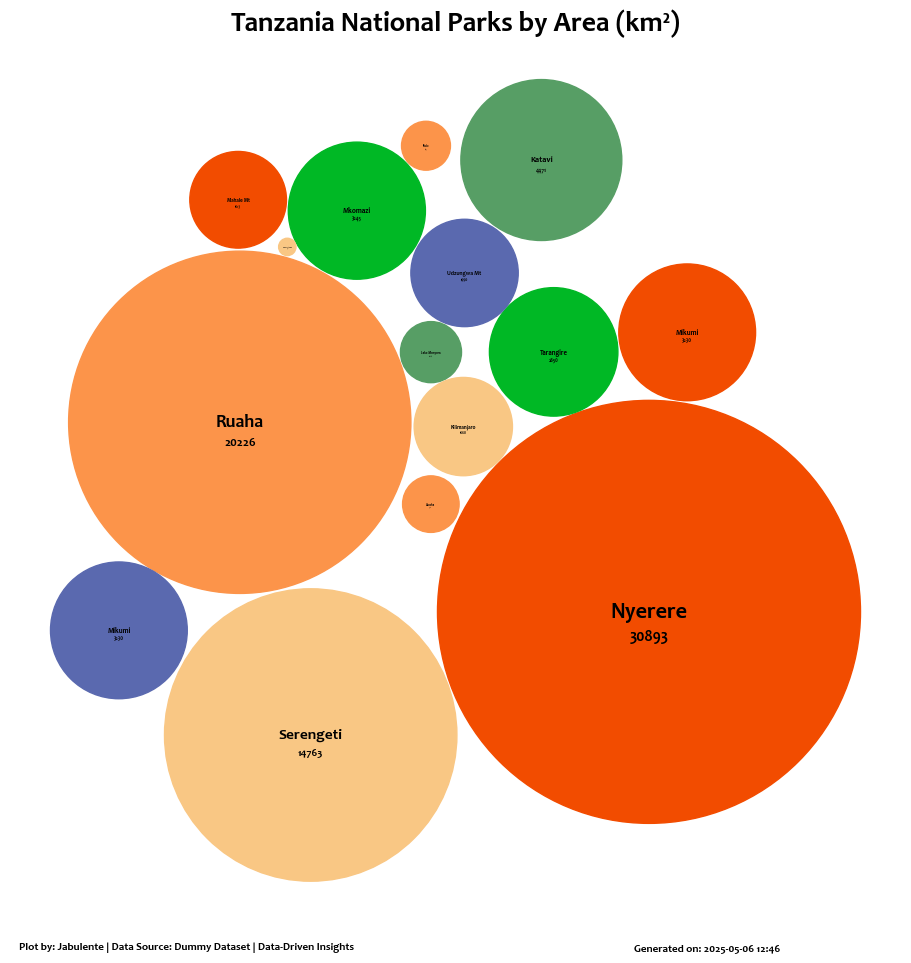

In [66]:
visualizer = BubbleChartVisualizer()
fig = visualizer.create_bubble_chart(
    data=national_parks,
    areas_column='Area (km²)',
    labels_column='Parke_Name',
    values_column='Area (km²)',
    colors_column='colors',
    title='Tanzania National Parks by Area (km²)',
    figsize=(10, 10), 
    bubble_spacing=0.5, 
    save_path='./Outputs/Figures/Tanzania_National_Parks.png',
    dpi=300
)
plt.show()

---

This analysis was performed by **Jabulente**, a passionate and dedicated data scientist with a strong commitment to using data to drive meaningful insights and solutions. For inquiries, collaborations, or further discussions, please feel free to reach out via.  

    
<div align="center">  
    
[![GitHub](https://img.shields.io/badge/GitHub-Jabulente-black?logo=github)](https://github.com/Jabulente)  [![LinkedIn](https://img.shields.io/badge/LinkedIn-Jabulente-blue?logo=linkedin)](https://linkedin.com/in/jabulente-208019349)  [![X (Twitter)](https://img.shields.io/badge/X-@Jabulente-black?logo=x)](https://x.com/Jabulente)  [![Instagram](https://img.shields.io/badge/Instagram-@Jabulente-purple?logo=instagram)](https://instagram.com/Jabulente)  [![Threads](https://img.shields.io/badge/Threads-@Jabulente-black?logo=threads)](https://threads.net/@Jabulente)  [![TikTok](https://img.shields.io/badge/TikTok-@Jabulente-teal?logo=tiktok)](https://tiktok.com/@Jabulente)  [![Email](https://img.shields.io/badge/Email-jabulente@hotmail.com-red?logo=gmail)](mailto:Jabulente@hotmail.com)  

</div>

<h1 style='font-size: 55px; color: Tomato; font-family: Colonna MT; font-weight: 700; text-align: center'>THE END</h1>